训练集缺失行：131 行
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:18:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


最佳参数组合： {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__scale_pos_weight': 3}
训练集 AUC：0.868
测试集 AUC：0.856
自动找到的最佳阈值：0.73

测试集分类报告：
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       110
           1       0.57      0.82      0.68        28

    accuracy                           0.84       138
   macro avg       0.76      0.83      0.79       138
weighted avg       0.87      0.84      0.85       138



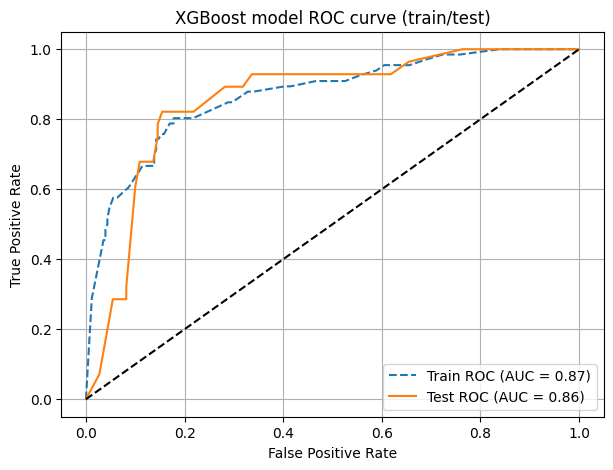

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt


# 1. 读取数据
data = pd.read_excel('/content/drive/MyDrive/总数据.xlsx')

# 2. 特征和标签
X = data[['LDH', 'PCT', 'NLR']]
y = data.iloc[:, -1]

# 3. 划分训练集和测试集，避免数据泄露
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# 4. 用训练集拟合多重插补模型
#缺失值采用多重插补方法处理，使用了基于链式方程的多变量插补（MICE, Multivariate Imputation by Chained Equations）方法
##插补模型为贝叶斯岭回归（Bayesian Ridge），最大迭代次数设为 20 次以确保收敛。
imputer = IterativeImputer(random_state=42, max_iter=20)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 5. 建立包含SMOTE的Pipeline，XGBoost模型
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 6. 参数网格，进行交叉验证调参
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__scale_pos_weight': [1, 3, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 7. 开始训练（训练集）
grid_search.fit(X_train_imputed, y_train)

# 8. 输出最佳参数
print("最佳参数组合：", grid_search.best_params_)

# 10. 用最佳模型预测训练集和测试集概率
xgb_train_prob = grid_search.best_estimator_.predict_proba(X_train_imputed)[:, 1]
xgb_test_prob = grid_search.best_estimator_.predict_proba(X_test_imputed)[:, 1]

# 11. 计算训练集和测试集 AUC
xgb_train_auc = roc_auc_score(y_train, xgb_train_prob)
xgb_test_auc = roc_auc_score(y_test, xgb_test_prob)
print(f"训练集 AUC：{xgb_train_auc:.3f}")
print(f"测试集 AUC：{xgb_test_auc:.3f}")

# 12. 根据Youden's Index自动找到最佳阈值
def find_best_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    youden_index = tpr - fpr
    best_threshold = thresholds[youden_index.argmax()]
    print(f"自动找到的最佳阈值：{best_threshold:.2f}")
    return best_threshold

best_threshold = find_best_threshold(y_test, xgb_test_prob)

# 13. 阈值调整预测
def threshold_predict(probs, threshold):
    return (probs >= threshold).astype(int)

y_test_pred_xgb = threshold_predict(xgb_test_prob, best_threshold)
print("\n测试集分类报告：")
print(classification_report(y_test, y_test_pred_xgb))

# 14. 绘制训练集和测试集 ROC曲线
fpr_train, tpr_train, _ = roc_curve(y_train, xgb_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, xgb_test_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {xgb_train_auc:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {xgb_test_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost model ROC curve (train/test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
最佳参数组合： {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
训练集 AUC：0.826
测试集 AUC：0.840
自动找到的最佳阈值：0.31

测试集分类报告：
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       110
           1       0.44      0.89      0.59        28

    accuracy                           0.75       138
   macro avg       0.70      0.80      0.70       138
weighted avg       0.86      0.75      0.77       138



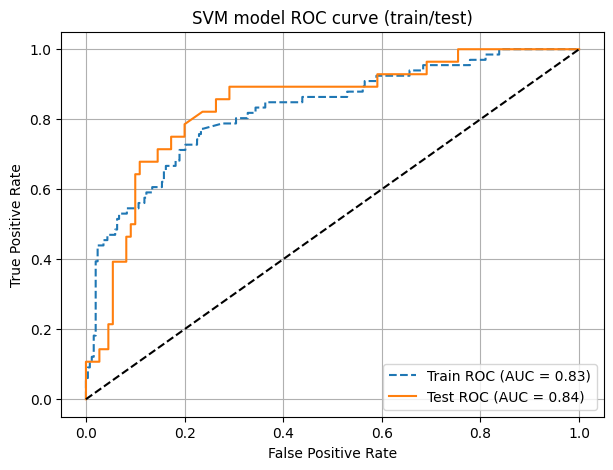

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# 5. 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 6. 建立包含SMOTE的Pipeline，支持向量机模型
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

# 7. 参数网格，进行交叉验证调参
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 1],
    'svm__kernel': ['linear', 'rbf']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 8. 开始训练（训练集）
grid_search.fit(X_train_scaled, y_train)

# 9. 输出最佳参数
print("最佳参数组合：", grid_search.best_params_)


# 11. 用最佳模型预测训练集和测试集概率
svm_train_prob = grid_search.best_estimator_.predict_proba(X_train_scaled)[:, 1]
svm_test_prob = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# 12. 计算训练集和测试集 AUC
svm_train_auc = roc_auc_score(y_train, svm_train_prob)
svm_test_auc = roc_auc_score(y_test, svm_test_prob)
print(f"训练集 AUC：{svm_train_auc:.3f}")
print(f"测试集 AUC：{svm_test_auc:.3f}")

# 13. 根据Youden's Index自动找到最佳阈值
def find_best_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    youden_index = tpr - fpr
    best_threshold = thresholds[youden_index.argmax()]
    print(f"自动找到的最佳阈值：{best_threshold:.2f}")
    return best_threshold

best_threshold = find_best_threshold(y_test, svm_test_prob)

# 14. 阈值调整预测
def threshold_predict(probs, threshold):
    return (probs >= threshold).astype(int)

y_test_pred_svm = threshold_predict(svm_test_prob, best_threshold)
print("\n测试集分类报告：")
print(classification_report(y_test, y_test_pred_svm))

# 15. 绘制训练集和测试集 ROC曲线
fpr_train, tpr_train, _ = roc_curve(y_train, svm_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, svm_test_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {svm_train_auc:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {svm_test_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM model ROC curve (train/test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Fitting 5 folds for each of 18 candidates, totalling 90 fits
最佳参数组合： {'rf__max_depth': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
训练集 AUC：0.870
测试集 AUC：0.859
自动找到的最佳阈值：0.53

测试集分类报告：
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       110
           1       0.58      0.79      0.67        28

    accuracy                           0.84       138
   macro avg       0.76      0.82      0.78       138
weighted avg       0.87      0.84      0.85       138



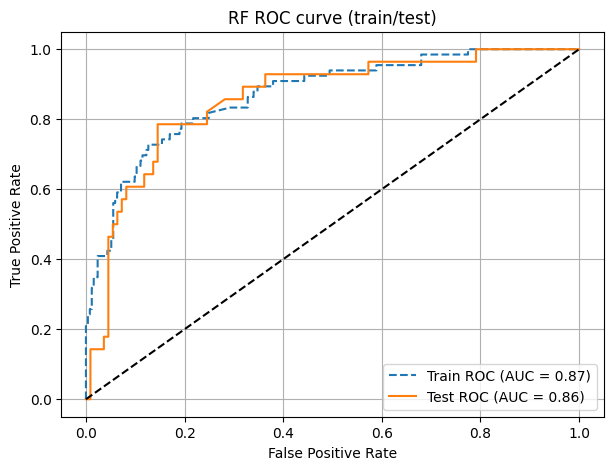

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# 6. 建立包含SMOTE的Pipeline，随机森林模型
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# 7. 参数网格，交叉验证调参
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [3, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 8. 训练模型
grid_search.fit(X_train_imputed, y_train)
print("最佳参数组合：", grid_search.best_params_)

# 10. 用最佳模型预测训练集和测试集概率
rf_train_prob = grid_search.best_estimator_.predict_proba(X_train_imputed)[:, 1]
rf_test_prob = grid_search.best_estimator_.predict_proba(X_test_imputed)[:, 1]

# 11. 计算训练集和测试集 AUC
rf_train_auc = roc_auc_score(y_train, rf_train_prob)
rf_test_auc = roc_auc_score(y_test, rf_test_prob)
print(f"训练集 AUC：{rf_train_auc:.3f}")
print(f"测试集 AUC：{rf_test_auc:.3f}")

# 12. 找到最佳阈值
def find_best_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    youden_index = tpr - fpr
    best_threshold = thresholds[youden_index.argmax()]
    print(f"自动找到的最佳阈值：{best_threshold:.2f}")
    return best_threshold

best_threshold = find_best_threshold(y_test, rf_test_prob)

# 13. 阈值调整预测
def threshold_predict(probs, threshold):
    return (probs >= threshold).astype(int)

y_test_pred_rf = threshold_predict(rf_test_prob, best_threshold)
print("\n测试集分类报告：")
print(classification_report(y_test, y_test_pred_rf))

# 14. 绘制训练集和测试集 ROC曲线
fpr_train, tpr_train, _ = roc_curve(y_train, rf_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, rf_test_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {rf_train_auc:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {rf_test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve (train/test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
##训练集AUC的95%置信区间Bootstrap法
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.RandomState(42)
    bootstrapped_scores = []

    for i in range(n_bootstraps):
        indices = rng.choice(range(len(y_scores)), size=len(y_scores), replace=True)
        if len(np.unique(np.array(y_true)[indices])) < 2:
            continue
        score = roc_auc_score(np.array(y_true)[indices], np.array(y_scores)[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    auc = roc_auc_score(y_true, y_scores)
    return auc, lower, upper

# 9. 输出各模型AUC及其置信区间
auc, lower, upper = bootstrap_auc_ci(y_train, xgb_train_prob)
print(f"XGBoost模型 AUC: {auc:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

auc, lower, upper = bootstrap_auc_ci(y_train, rf_train_prob)
print(f"随机森林模型 AUC: {auc:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

auc, lower, upper = bootstrap_auc_ci(y_train, svm_train_prob)
print(f"SVM模型 AUC: {auc:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

XGBoost模型 AUC: 0.868 (95% CI: 0.814 - 0.915)
随机森林模型 AUC: 0.870 (95% CI: 0.817 - 0.916)
SVM模型 AUC: 0.826 (95% CI: 0.764 - 0.883)


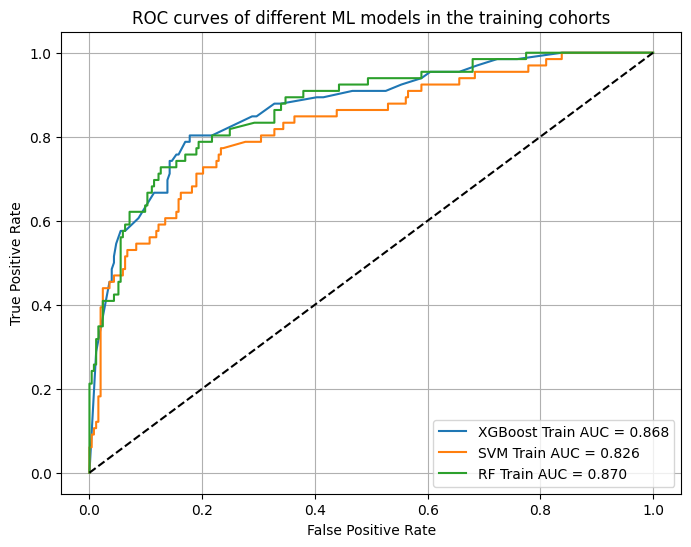

In [ ]:
# 7. 绘制训练集ROC曲线
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, xgb_train_prob)
fpr_svm, tpr_svm, _ = roc_curve(y_train, svm_train_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_train, rf_train_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost Train AUC = {xgb_train_auc:.3f}')
plt.plot(fpr_svm, tpr_svm, label=f'SVM Train AUC = {svm_train_auc:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF Train AUC = {rf_train_auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of different ML models in the training cohorts')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
plt.savefig("train_roc_curve.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [ ]:
##测试集AUC的95%置信区间Bootstrap法
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.RandomState(42)
    bootstrapped_scores = []

    for i in range(n_bootstraps):
        indices = rng.choice(range(len(y_scores)), size=len(y_scores), replace=True)
        if len(np.unique(np.array(y_true)[indices])) < 2:
            continue
        score = roc_auc_score(np.array(y_true)[indices], np.array(y_scores)[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    auc = roc_auc_score(y_true, y_scores)
    return auc, lower, upper

# 9. 输出各模型测试集AUC及其置信区间
auc, lower, upper = bootstrap_auc_ci(y_test, xgb_test_prob)
print(f"XGBoost模型 AUC: {auc:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

auc, lower, upper = bootstrap_auc_ci(y_test, rf_test_prob)
print(f"随机森林模型 AUC: {auc:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

auc, lower, upper = bootstrap_auc_ci(y_test, svm_test_prob)
print(f"SVM模型 AUC: {auc:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

XGBoost模型 AUC: 0.856 (95% CI: 0.773 - 0.925)
随机森林模型 AUC: 0.859 (95% CI: 0.772 - 0.930)
SVM模型 AUC: 0.840 (95% CI: 0.751 - 0.917)


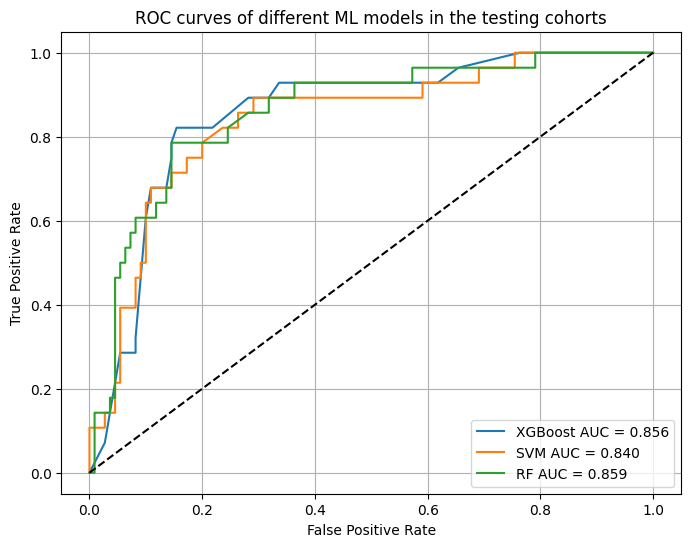

In [ ]:
#绘制测试集ROC曲线
plt.figure(figsize=(8, 6))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_test_prob)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_test_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_prob)

plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {xgb_test_auc:.3f}')
plt.plot(fpr_svm, tpr_svm, label=f'SVM AUC = {svm_test_auc:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC = {rf_test_auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--')  # 参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of different ML models in the testing cohorts')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
plt.savefig('test_roc_comparison.png', dpi=300)

<Figure size 640x480 with 0 Axes>

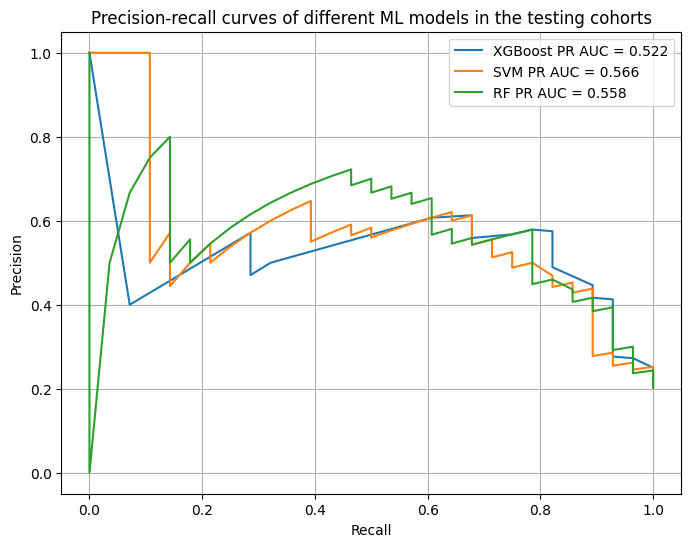

In [ ]:
##PR曲线
from sklearn.metrics import precision_recall_curve, auc
# 计算XGBoost的曲线
precision1, recall1, _ = precision_recall_curve(y_test, xgb_test_prob)
pr_auc1 = auc(recall1, precision1)

# 计算SVM的曲线
precision2, recall2, _ = precision_recall_curve(y_test, svm_test_prob)
pr_auc2 = auc(recall2, precision2)

# 计算RF的曲线
##RF模型由于其概率输出的离散性及测试集中正类样本较少，曲线有较明显的跳跃。这是小样本背景下较为常见的现象，并不代表模型本身性能不佳
precision3, recall3, _ = precision_recall_curve(y_test, rf_test_prob)
pr_auc3 = auc(recall3, precision3)

# 绘制对比图
plt.figure(figsize=(8, 6))
plt.plot(recall1, precision1, label=f'XGBoost PR AUC = {pr_auc1:.3f}')
plt.plot(recall2, precision2, label=f'SVM PR AUC = {pr_auc2:.3f}')
plt.plot(recall3, precision3, label=f'RF PR AUC = {pr_auc3:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curves of different ML models in the testing cohorts')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
#统一计算评估指标
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # 敏感性
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    gmean = (recall * specificity) ** 0.5
    f1 = f1_score(y_true, y_pred)

    return {
        "模型": model_name,
        "准确率": round(accuracy, 3),
        "精确率": round(precision, 3),
        "敏感性": round(recall, 3),
        "特异度": round(specificity, 3),
        "G-均值": round(gmean, 3),
        "F1分数": round(f1, 3)
    }
# 三个模型的预测结果
svm_result = calculate_metrics(y_test, y_test_pred_svm, "SVM")
xgb_result = calculate_metrics(y_test, y_test_pred_xgb, "XGBoost")
rf_result = calculate_metrics(y_test, y_test_pred_rf, "RF")

# 合并成表格
results_table = pd.DataFrame([svm_result, xgb_result,rf_result])

# 显示表格
print(results_table)


        模型    准确率    精确率    敏感性    特异度   G-均值   F1分数
0      SVM  0.746  0.439  0.893  0.709  0.796  0.588
1  XGBoost  0.841  0.575  0.821  0.845  0.833  0.676
2       RF  0.841  0.579  0.786  0.855  0.819  0.667


In [ ]:
# 保存到Excel
results_table.to_excel('/content/drive/MyDrive/模型性能对比表.xlsx', index=False)